In [14]:
import matplotlib.pyplot as plt
import string
from skimage.restoration import denoise_tv_chambolle
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
from skimage.exposure import rescale_intensity
import numpy as np
import logging

def removeSpace(img):
    mask = img == 1
    rows = np.flatnonzero((~mask).sum(axis=1))
    cols = np.flatnonzero((~mask).sum(axis=0))
    crop = img[rows.min():rows.max()+1, cols.min():cols.max()+1]
    return crop
    
def symmetrize(img):
    dim = max(img.shape)
    emptySpace = [1]*dim
    #less rows
    if img.shape[0] < dim: 
        top = round((dim-img.shape[0])/2)
        bot = dim-top-img.shape[0]
        
        newImg = np.vstack((np.array(top*[emptySpace]), img)) if top > 0 else img
        newImg = np.vstack((newImg, np.array(bot*[emptySpace]))) if bot > 0 else newImg
        return newImg
    #less cols
    else:  
        left = round((dim-img.shape[1])/2)
        right = dim-left-img.shape[1]
        
        newImg = np.hstack((np.transpose(np.array(left*[emptySpace])), img)) if left > 0 else img
        newImg = np.hstack((newImg, np.transpose(np.array(right*[emptySpace]))))if right > 0 else newImg
        return newImg
    

counts = [64, 63, 63, 63, 62, 62, 61, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]    
imgs = []
cat = []
i=0
# NOTE: Change this variable to set correct location of letter data in your computer #
PATH_TO_LETTERS='letters/'                                                           #
######################################################################################
for alph in string.ascii_uppercase:
    for idx in range(1, counts[i]+1):
        try:
            img = plt.imread(f"{PATH_TO_LETTERS}{alph}{idx}.png")
            img = denoise_tv_chambolle(img, weight=0.1, multichannel=True, n_iter_max=10)
            img = rgb2gray(img)
            thresh = threshold_otsu(img)
            img = (img > thresh).astype(int)
            img = removeSpace(img)
            img = symmetrize(img)
            img *= 255 # Change grayscale interval
            img = gaussian(img, sigma=5, preserve_range=True).astype(int)
            img = resize(img, (8, 8))
            img = rescale_intensity(img, out_range=(0, 16))
        
            imgs.append((img, i, alph))
            cat.append(i)
        except ValueError as ve:
            print(f"Error processing picture {alph}{idx}.png, skipping...")
            continue
    i += 1
            

Error processing picture A22.png, skipping...
Error processing picture B21.png, skipping...
Error processing picture C21.png, skipping...
Error processing picture D21.png, skipping...
Error processing picture F20.png, skipping...
Error processing picture G19.png, skipping...
Error processing picture H21.png, skipping...
Error processing picture I21.png, skipping...
Error processing picture J21.png, skipping...
Error processing picture K21.png, skipping...
Error processing picture L21.png, skipping...
Error processing picture M21.png, skipping...
Error processing picture N21.png, skipping...
Error processing picture O21.png, skipping...
Error processing picture P21.png, skipping...
Error processing picture Q21.png, skipping...
Error processing picture R21.png, skipping...
Error processing picture S21.png, skipping...
Error processing picture T21.png, skipping...
Error processing picture U21.png, skipping...
Error processing picture V21.png, skipping...
Error processing picture W21.png, 

77.86% of letter images classified correctly
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.66      0.83      0.74        30
           1       0.86      0.78      0.82        32
           2       0.96      0.83      0.89        29
           3       0.72      0.91      0.81        32
           4       0.77      0.82      0.79        33
           5       0.71      0.77      0.74        31
           6       0.90      0.70      0.79        27
           7       0.79      0.79      0.79        29
           8       0.87      0.76      0.81        34
           9       0.68      0.93      0.78        29
          10       0.80      0.86      0.83        28
          11       0.88      0.85     

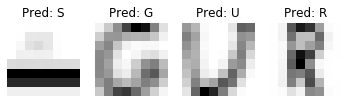

In [17]:
from sklearn import svm, metrics
import random

# Shuffle letter data and select half of them as the training set
random.shuffle(imgs)
traindata = [img[0].flatten() for img in imgs[0:int(len(imgs)/2)]]
labels = [img[1] for img in imgs[0:int(len(imgs)/2)]]
# Train svm
classifier = svm.SVC(gamma=0.001)
classifier.fit(traindata, labels)
# Select rest of the letter data as test set
testdata = [img[0].flatten() for img in imgs[int(len(imgs)/2+1):]]
corrLabel = np.array([img[1] for img in imgs[int(len(imgs)/2+1):]])
# Let svm predict the labels
predLabel = classifier.predict(testdata)

# Calculate precentage how well svm succeeded
prec = sum(predLabel == corrLabel) / len(testdata)

# Some statistics how classification succeeded
print(f'{round(prec*100, 2)}% of letter images classified correctly')

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(corrLabel, predLabel)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(corrLabel, predLabel))

images_and_predictions = list(zip([img[0] for img in imgs[int(len(imgs)/2+1):]], predLabel))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index +5)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.title(f'Pred: {string.ascii_uppercase[prediction]}')
    
plt.show()